In [1]:
# Not all of these will be used, remove as needed
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from skimage import io, filters, morphology
from skimage.util import img_as_ubyte
from skimage.filters import rank, sobel
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
import heapq

In [2]:
# List of files for Dan to test
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_1_2024-01-11_Confocal_01.00.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_2_2024-01-11_Confocal_01.16.28_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_1_2024-01-11_Confocal_01.23.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_3_2024-01-11_Confocal_01.40.34_DragonflyUser.ims'
# '/Users/moose/Downloads/Controls 20240418/PBP4_2024-04-18_Confocal_01.02.30_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 2_2024-01-10_Confocal_22.46.39_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 3_2024-01-11_Confocal_00.32.47_DragonflyUser.ims'
# '/Users/moose/Downloads/Controls 20240418/Nonporous_2024-04-18_Confocal_00.19.10_DragonflyUser.ims'

# Select Datasets
# '/Volumes/SSD/Mike/1.21 OD Device 4_6 Hours_2023-03-15_GFP Staph Aureus_22.39.28_DragonflyUser.ims'
# '/Volumes/SSD/Mike/Od 1.187 Device 1_6 hours_2023-03-03_GFP Staph Aureus_22.24.24_DragonflyUser.ims'
# '/Volumes/SSD/Mike/Od 1.187 Device 2_6 hours_2023-03-03_GFP Staph Aureus_21.44.39_DragonflyUser.ims'


# '/Users/moose/Downloads/Controls 20240418/WT DNase_2024-04-18_Confocal_00.55.19_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT 1 window_2024-04-18_Confocal_00.33.17_DragonflyUser_FusionStitcher.ims' Do not use!

# '/Users/moose/Downloads/Controls 20240418/WT 1 stack_2024-04-18_Confocal_00.48.57_DragonflyUser.ims' Good test stack for budding events, slightly tilted.

In [3]:
# Load raw ims file here

file_name = '/Users/moose/Downloads/Analysis Data Set 06212024/Nonporous_1_2024-06-21_Confocal_00.39.39_DragonflyUser.ims'
image = AICSImage(file_name)
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [4]:
# Global variables
key_frame = '/Users/moose/Desktop/trace_ca-local/key-frame-ca-norm2.tif'
key_img = io.imread(key_frame)
norm_flat = key_img # Need to fix in code for clarity, this variable is redundant.

# Some of these are not used, remove later
DoG_thresh = 0.3
lowerbound = 2
search_mod = 25
z_project = 10
bloom_mod = 1

BlurToggle = False
gkernal = (21, 21)

DilateToggle = False
dstructure = np.ones((3, 3))

In [5]:
# All functions
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

def means_match(input_img, kfimg):
        # kfmod = subtractflatfield(kfimg)
        # kfmod = kfmod-np.min(kfmod)
        kfmod = kfimg
        kfmean = np.mean(kfmod)

        # xmod_loss = []

        best_mean_diff = np.inf
        best_xmod = 0
        mean_diff = 0
        bftest = input_img
        bfmin = np.min(bftest)
            
        for xmod in tqdm(np.linspace(0.01, 10, 500), desc='Means Matching'):
            xmodtest = np.clip(xmod * (bftest), np.min(kfimg), np.max(kfimg))
            mean_xmodtest = np.mean(xmodtest)
            mean_diff = abs(mean_xmodtest - kfmean)

            # xmod_loss = mean_diff # Diagnostic
                
            if mean_diff < best_mean_diff:
                best_mean_diff = mean_diff
                best_xmod = xmod

            if mean_diff < 0.0005:
                print(f'Image is at an acceptable target, stopping iterations')
                break

            bfimg = np.clip(best_xmod * (input_img - np.min(input_img)), np.min(kfimg), np.max(kfimg))

        return bfimg, kfmod, best_xmod

In [6]:
flattened_im_data = []
for i in tqdm(range(len(image_data)), desc='Removing background from stack'):
    flattened_im_data.append(subtractflatfield(image_data[i]))

Removing background from stack: 100%|██████████| 41/41 [00:17<00:00,  2.35it/s]


In [7]:
# Initial image processing
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

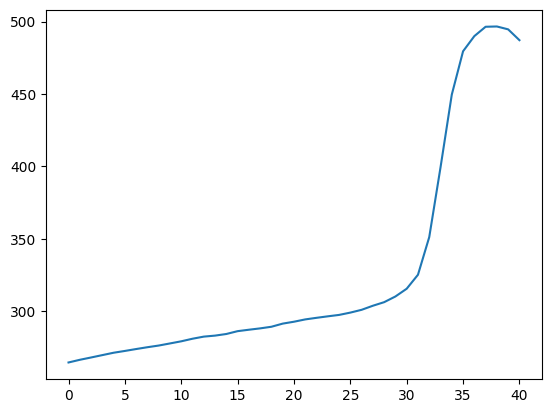

In [8]:
plt.plot(frame_mean, label='Mean')

In [9]:
# Peak detection
background_collect = background_subtract(frame_mean)
peaks2, _ = find_peaks(background_collect, height = 1)

if len(peaks2) == 0:
    max_key = {}
    for i in range(len(background_collect)):
        max_key[i] = background_collect[i]
    true_max = max(max_key.keys())
    peaks2 = [true_max]

if len(peaks2) > 1:
    print('Multiple peaks detected, selecting the highest peak')
    max_key = {}
    for i in range(len(background_collect)):
        max_key[i] = background_collect[i]
    true_max = max(max_key.keys())
    peaks2 = [true_max]

print(peaks2)

[38]


In [10]:
# Generate ensemble model for focus measure voting
hist_key = {}

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

hist_laplace = {}
hist_laplace_focusemeasure = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

hist_tenengrad_focusemeasure = {}
hist_squared_grad = {}
for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)
    squared_grad = (sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)
    hist_squared_grad[i] = np.var(squared_grad)


hist_brenner_focusemeasure = {}
for i in hist_key.keys():
    shifted_right = np.roll(hist_key[i], -1, axis=1)
    shifted_down = np.roll(hist_key[i], -1, axis=0)

    diff_right = (shifted_right - hist_key[i])[:-1, :-1] ** 2
    diff_down = (shifted_down - hist_key[i])[:-1, :-1] ** 2

    sum_diff = np.sum(diff_right) + np.sum(diff_down)
    hist_brenner_focusemeasure[i] = sum_diff

hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [11]:
# Finalize vote

weight_mat = [1, 1, 1, 1, 1, 1]
focus_margins = []

# stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
# laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
# tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))
squared_grad_stdev = np.std(list(hist_squared_grad.values()))
brenner_stdev = np.std(list(hist_brenner_focusemeasure.values()))


weight_mat[0] = stdev_stdev/np.mean(list(hist_stdev.values()))
weight_mat[1] = laplace_stdev/np.mean(list(hist_laplace_focusemeasure.values()))
weight_mat[2] = tenengrad_stdev/np.mean(list(hist_tenengrad_focusemeasure.values()))
weight_mat[3] = squared_grad_stdev/np.mean(list(hist_squared_grad.values()))
weight_mat[4] = brenner_stdev/np.mean(list(hist_brenner_focusemeasure.values()))

focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))
focus_ensemble.append(max(hist_squared_grad, key=hist_squared_grad.get))
focus_ensemble.append(max(hist_brenner_focusemeasure, key=hist_brenner_focusemeasure.get))

voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote

print(f'Final Vote - Membrane Layer at:  ' + str(max(vote, key=vote.get)))
mem_layer = max(vote, key=vote.get)

Final Vote - Membrane Layer at:  34


In [12]:
# Create z-projection

bud_test = []
for i in range(z_project):
    bud_test.append(mem_layer-i-bloom_mod)

bud_test_img = []
for i in bud_test:
    bud_test_img.append(flattened_im_data[i])

bud_composite = np.max(bud_test_img, axis=0)

bud_img = bud_composite

In [13]:
# Process z-projection and normalize brightness.
# bud_norm = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
# bud_norm = img_as_ubyte(bud_norm)


bud_sub = bud_img
bud_sub = (bud_sub - np.min(bud_sub)) / (np.max(bud_sub) - np.min(bud_sub))
bud_sub = img_as_ubyte(bud_sub)  


bud_matched, kf_fin,  xtest = means_match(bud_sub, norm_flat)

Means Matching:   0%|          | 0/500 [00:00<?, ?it/s]

Means Matching: 100%|██████████| 500/500 [00:03<00:00, 132.18it/s]


In [14]:
xtest

2.4124048096192383

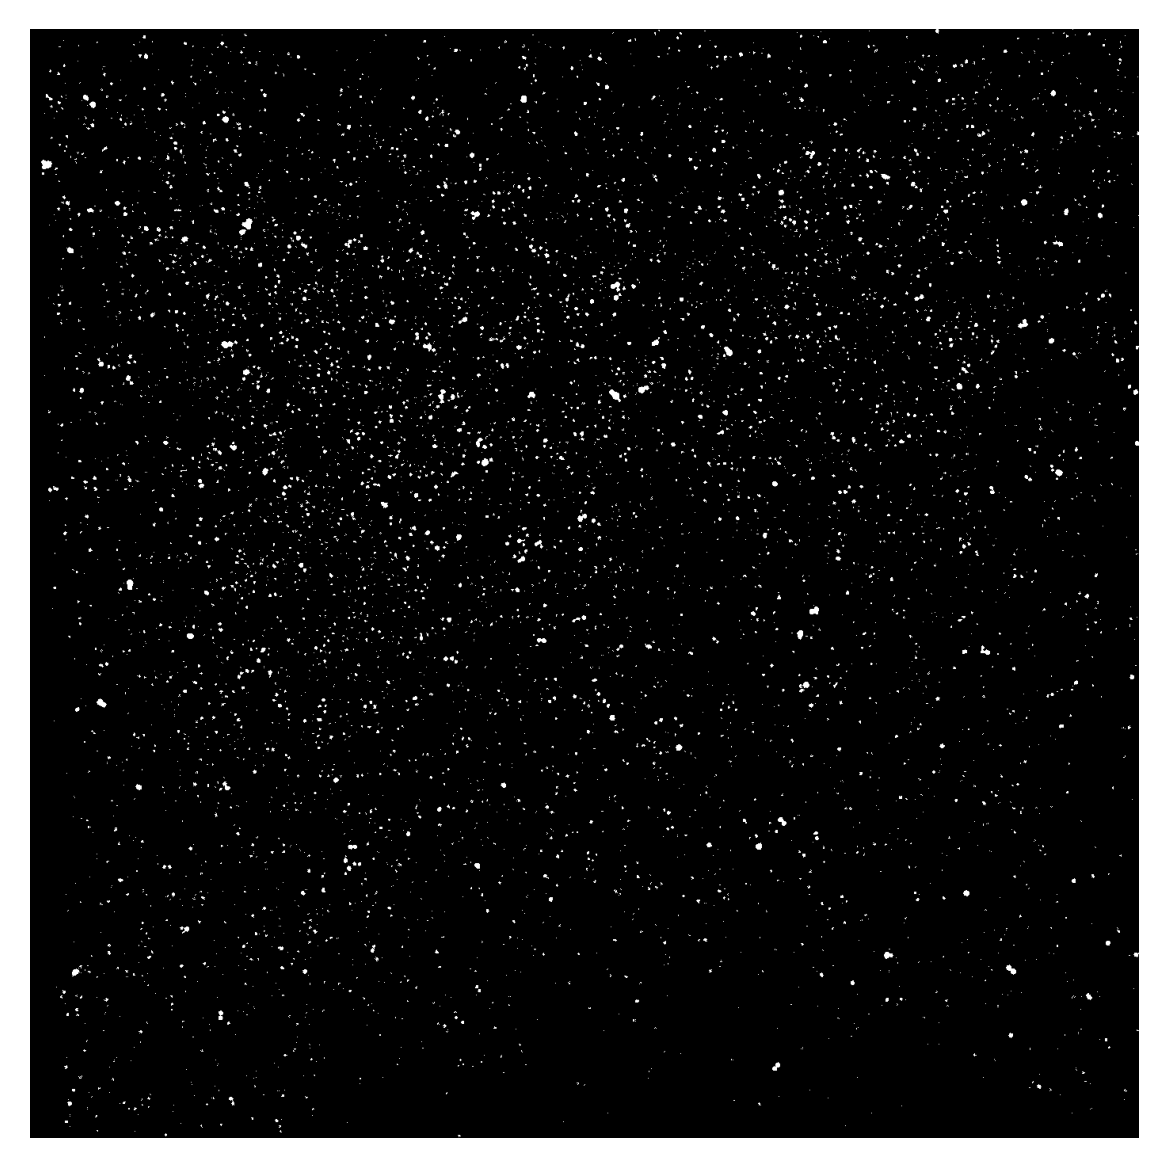

Raw Regions: 6463
Filtered Regions: 56


In [15]:
# Image processing for budding events
# Threshold image
bud_thresh = np.percentile(bud_matched, 98)
bud_brightest = np.where(bud_matched > bud_thresh, 256, 0)

plt.figure(dpi=300)
plt.imshow(bud_brightest, cmap='gray')
plt.axis('off')
# plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_binary.tif', dpi=500)
plt.show()

# Morphological analysis
closed_im = morphology.closing(bud_brightest, morphology.square(1))
label_im = measure.label(closed_im)
region_im = measure.regionprops(label_im, intensity_image=bud_matched)
# for part in region_im:
#     print('Label: {} Area: {}'.format(part.label, part.area))

area_list = []
for part in region_im:
    area_list.append(part.area)

# delete_small_components = filters.threshold_otsu(np.array(area_list)) 
# area_list = [part for part in area_list if delete_small_components < part < 10000]

intensity_list = []
for part in region_im:
    intensity_list.append(part.mean_intensity)

int_cut = np.percentile(intensity_list, 50)
intensity_list = [part for part in intensity_list if  int_cut < part]

eccentricity_list = []
for part in region_im:
    eccentricity_list.append(part.eccentricity)

eccentricity_list = [part for part in eccentricity_list if 0.05 < part < 0.99]

area_list_thresh = np.percentile(area_list, 98)
mean_comp = np.percentile(intensity_list, 98)
# std_mean_comp = np.std([part for part in intensity_list if part > mean_comp])
# mean_comp = np.percentile(norm_flat, 99.8)
lower_ecc = np.percentile(eccentricity_list, 2)
higher_ecc = np.percentile(eccentricity_list, 98)

filter_area_low = area_list_thresh 
filter_eccentricity_low = lower_ecc
filter_eccentricity_high = higher_ecc
# region_im_filtered = [part for part in region_im if part.mean_intensity > mean_comp]
# region_im_filtered = [part for part in region_im_filtered if filter_area_low < part.area < 10000]
# region_im_filtered = [part for part in region_im_filtered if filter_eccentricity_low < part.eccentricity < filter_eccentricity_high]

region_im_filtered = [
                      part for part in region_im 
                      if part.intensity_mean > np.max([mean_comp, 135])
                      and np.max([filter_area_low, 15]) < part.area < 10000 
                      and filter_eccentricity_low < part.eccentricity < filter_eccentricity_high
                      and part.intensity_max > 225
                      and part.intensity_max - part.intensity_mean > 25
                      ]

print('Raw Regions: {}'.format(len(region_im)))
print('Filtered Regions: {}'.format(len(region_im_filtered)))

In [16]:
for part in region_im_filtered:
      print('Centroid: ({:.0f}, {:.0f}) | '
            'Area: {} | '
            'Eccentricity {:.2f} | '
            'Mean Intensity {:.2f} | '
            'Max Intensity {:.2f}'.format(part.centroid[0], 
                                          part.centroid[1], 
                                          part.area, 
                                          part.eccentricity, 
                                          part.mean_intensity, 
                                          part.intensity_max))

Centroid: (81, 1291) | Area: 38.0 | Eccentricity 0.54 | Mean Intensity 199.52 | Max Intensity 255.00
Centroid: (88, 623) | Area: 61.0 | Eccentricity 0.57 | Mean Intensity 228.40 | Max Intensity 255.00
Centroid: (95, 79) | Area: 49.0 | Eccentricity 0.41 | Mean Intensity 207.40 | Max Intensity 255.00
Centroid: (171, 20) | Area: 119.0 | Eccentricity 0.54 | Mean Intensity 204.87 | Max Intensity 255.00
Centroid: (186, 1079) | Area: 55.0 | Eccentricity 0.87 | Mean Intensity 191.13 | Max Intensity 255.00
Centroid: (234, 562) | Area: 72.0 | Eccentricity 0.57 | Mean Intensity 184.09 | Max Intensity 255.00
Centroid: (235, 1350) | Area: 33.0 | Eccentricity 0.57 | Mean Intensity 217.52 | Max Intensity 255.00
Centroid: (246, 274) | Area: 118.0 | Eccentricity 0.57 | Mean Intensity 219.23 | Max Intensity 255.00
Centroid: (251, 146) | Area: 29.0 | Eccentricity 0.65 | Mean Intensity 195.75 | Max Intensity 255.00
Centroid: (256, 268) | Area: 46.0 | Eccentricity 0.69 | Mean Intensity 207.93 | Max Intensi

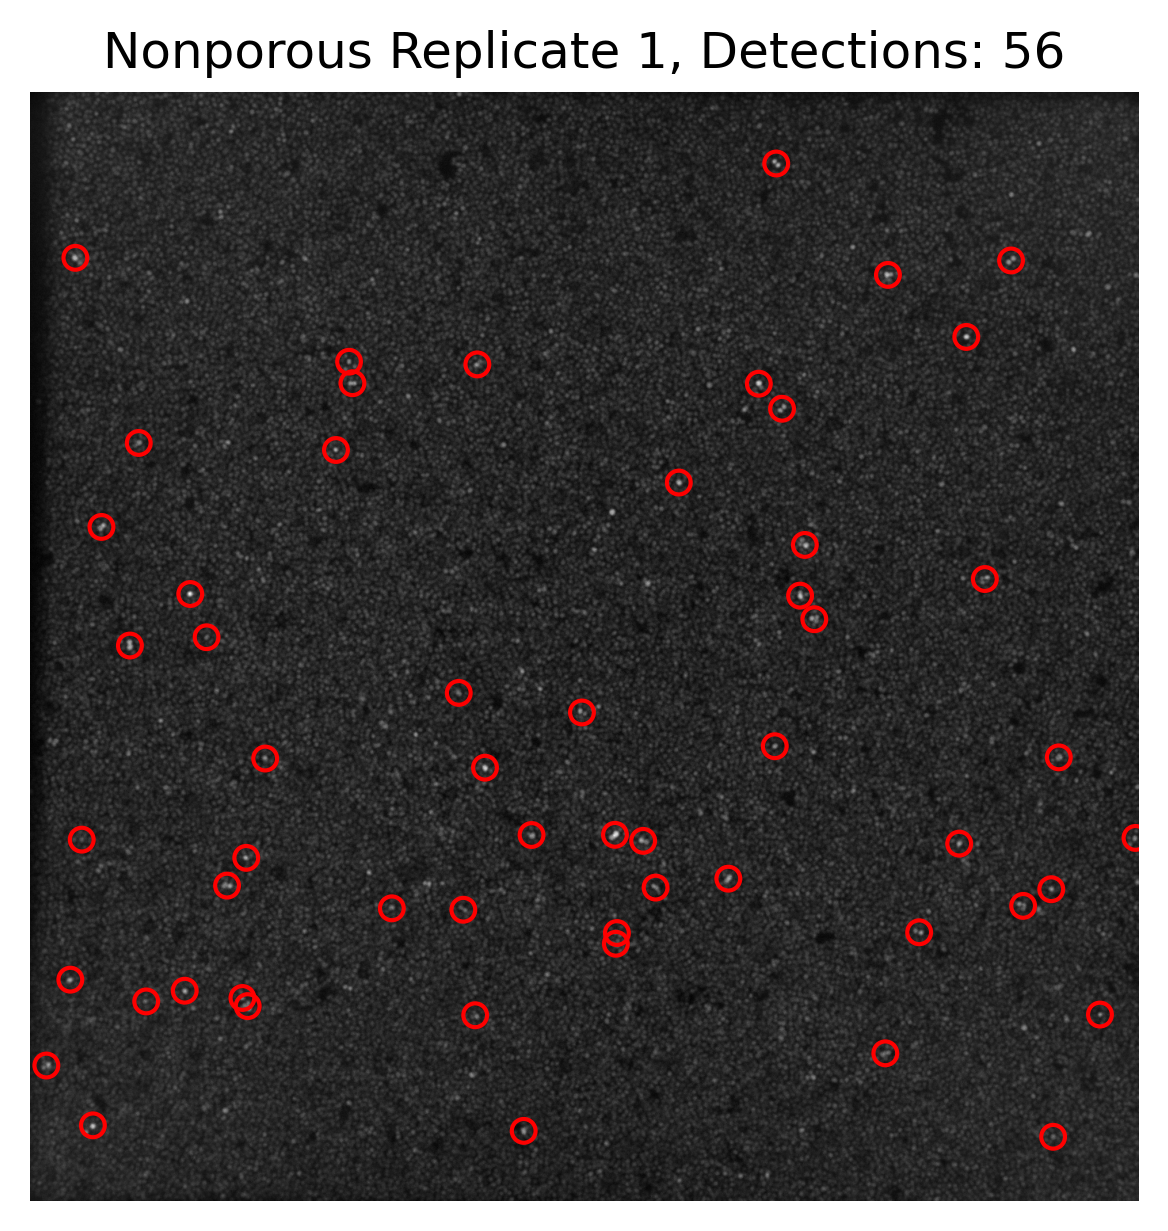

In [17]:
fig_alt, ax_alt = plt.subplots(dpi=300)
ax_alt.imshow(flattened_im_data[mem_layer], cmap='gray')
for region in region_im_filtered:
    y, x = region.centroid
    radius = np.sqrt(region.area / np.pi)

    circle = plt.Circle((x, y), np.where(radius*5 < 15, radius*5, 15), fill=False, edgecolor='red')
    ax_alt.add_patch(circle)
   
ax_alt.invert_yaxis()
plt.axis('off')
plt.title(os.path.basename(file_name).split('_')[0] + ' Replicate ' + os.path.basename(file_name).split('_')[1] + ', ' + 'Detections: ' + str(len(region_im_filtered)) )
plt.show()

In [18]:
voting_block = []
voting_block.append('STDEV')
voting_block.append('LAPLACE')
voting_block.append('TENENGRAD')
voting_block.append('SQUARED_GRAD')
voting_block.append('BRENNER')
vote_stats = []
for i in range(len(voting_power)):
    vote_stats.append([])

for i in range(len(vote_stats)):
    vote_stats[i] = (voting_block[i], voting_power[i])

In [19]:
for i in range(len(voting_power)):
    print(f'{voting_power[i][0]}, {voting_power[i][1]}')

34, 0.2675786783861533
35, 0.37493692732383
34, 1.5302563632419492
34, 1.9939927484260493
34, 0.6167852408261596


In [20]:
vote

{34: 4.4086130308803115, 35: 0.37493692732383}

In [21]:
dfCoords = pd.DataFrame(columns=['Centroid X', 'Centroid Y', 'Area', 'Eccentricity', 'Mean Intensity', 'Max Intensity'])
for part in region_im_filtered:
    dfCoords = dfCoords._append({'Centroid X': part.centroid[0], 
        'Centroid Y': part.centroid[1], 
        'Area': part.area, 
        'Eccentricity': part.eccentricity, 
        'Mean Intensity': part.mean_intensity, 
        'Max Intensity': part.intensity_max}, ignore_index=True)

/var/folders/p0/tb_jc0zs6z383snrfzw6d5_00000gn/T/ipykernel_58533/1837445146.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCoords = dfCoords._append({'Centroid X': part.centroid[0],


In [22]:
dfCoords

,Centroid X,Centroid Y,Area,Eccentricity,Mean Intensity,Max Intensity
0,80.578947,1291.342105,38.0,0.538655,199.519502,255.000000
1,88.049180,622.868852,61.0,0.566650,228.396226,255.000000
2,95.020408,78.918367,49.0,0.408156,207.395662,255.000000
3,170.554622,20.151261,119.0,0.543600,204.871930,255.000000
4,185.945455,1079.454545,55.0,0.871836,191.133922,255.000000
5,234.013889,561.611111,72.0,0.571257,184.091042,255.000000
6,234.909091,1350.454545,33.0,0.571882,217.522506,255.000000
7,245.567797,274.355932,118.0,0.570973,219.234237,255.000000
8,251.482759,146.241379,29.0,0.652341,195.746765,255.000000
9,255.847826,267.695652,46.0,0.688290,207.930999,255.000000


In [23]:
masks = []
for prop in region_im_filtered:
    masks.append(prop.intensity_image)

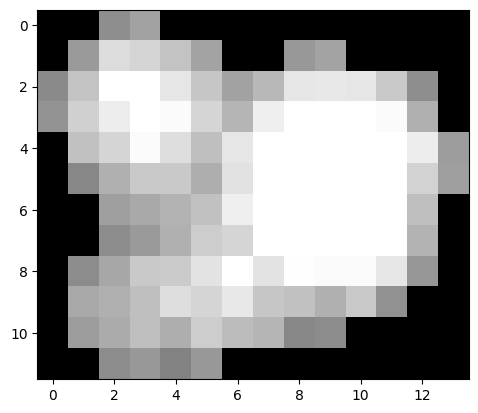

In [24]:
plt.imshow(masks[3], cmap='gray')

In [25]:
# # Need to use cv2.imwrite or else some small images will get corrupted! (Saved as 1-line RGB image? Weird)
# for i in range(len(masks)):
#     masks[i] = np.array(masks[i], dtype=np.uint8)
#     cv2.imwrite('/Users/moose/Desktop/trace_ca-local/LogRegImages/True/' + os.path.splitext(os.path.basename(file_name))[0] + '_mask_' + str(i) + '.tif', masks[i])

In [26]:
boundingbox = []
for prop in region_im_filtered:
    boundingbox.append(prop.bbox)

allboxes = []
for i in range(len(boundingbox)):
    diffb = [abs(boundingbox[i][2] - boundingbox[i][0]), abs(boundingbox[i][3] - boundingbox[i][1])]
    allboxes.append(diffb)

In [27]:
max(max(allboxes))

16

In [28]:
bounded_stack = []
for i in range(len(region_im_filtered)):
    bounded_stack.append([])

for i in range(len(region_im_filtered)):
    min_row, min_col, max_row, max_col = region_im_filtered[i].bbox
    for j in range(mem_layer-5, mem_layer):
        sub_image = image_data[j][min_row:max_row, min_col:max_col]
        bounded_stack[i].append(sub_image)

In [29]:
# stack_check = 1

# fig, axs = plt.subplots(1, len(bounded_stack[stack_check]), figsize=(25, 5)) 

# for i in range(len(bounded_stack[stack_check])):
#     axs[i].imshow(bounded_stack[stack_check][i], cmap='gray')  
#     axs[i].axis('off') 

# plt.tight_layout() 
# plt.show() 

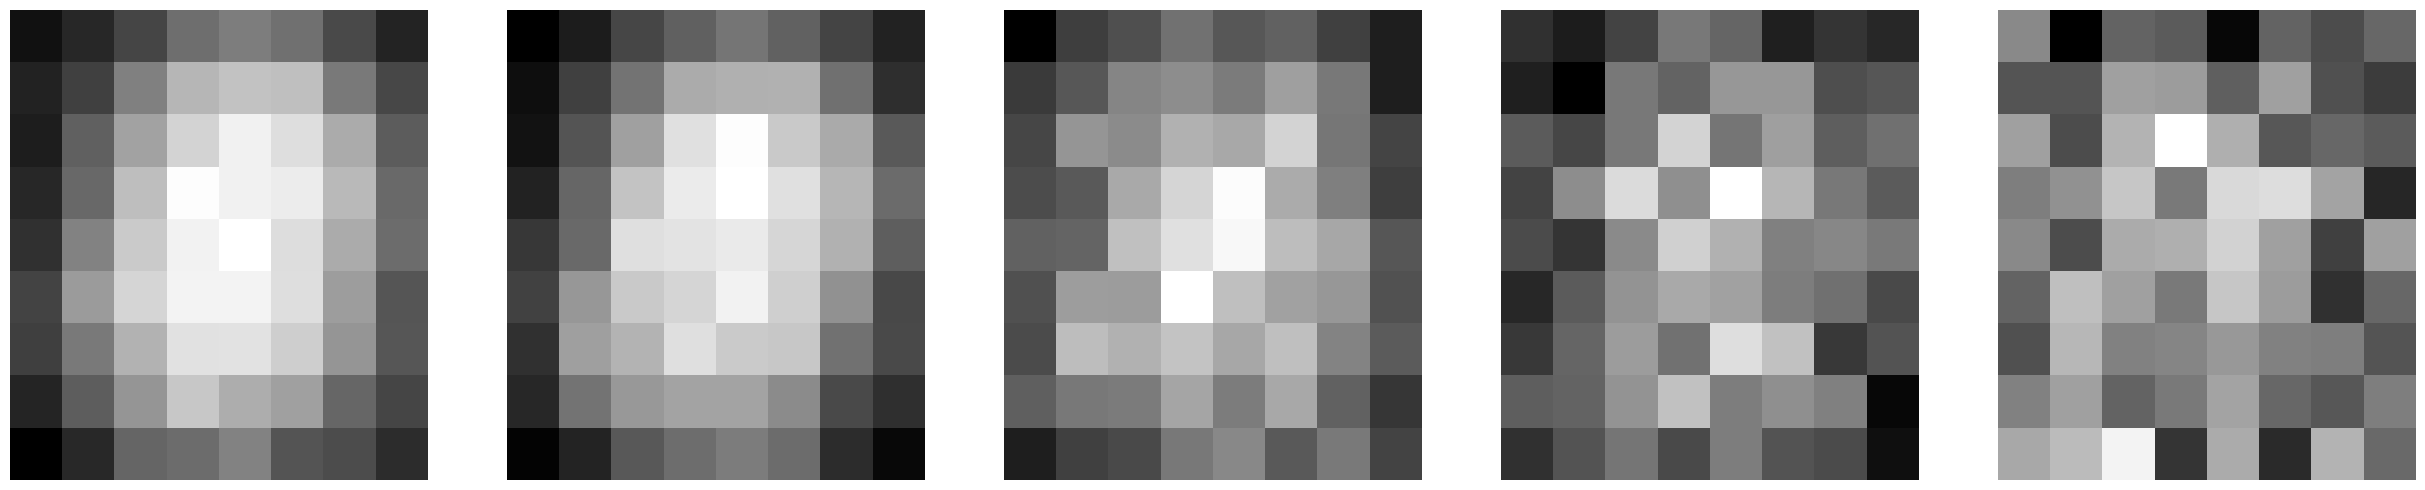

In [30]:
stack_check = 1

fig, axs = plt.subplots(1, len(bounded_stack[stack_check]), figsize=(25, 5)) 

# Iterate in reverse order
for i in range(len(bounded_stack[stack_check])-1, -1, -1):
    axs[len(bounded_stack[stack_check])-1-i].imshow(bounded_stack[stack_check][i], cmap='gray')  
    axs[len(bounded_stack[stack_check])-1-i].axis('off') 

plt.tight_layout() 
plt.show()

In [31]:
def edge_density(image):
    edges = sobel(image)
    return edges.mean()

In [32]:
edge_stack = []
for i in range(len(bounded_stack)):
    edge_stack.append([])

for i in range(len(bounded_stack)):
    for j in range(len(bounded_stack[i])):
        edge_stack[i].append(edge_density(bounded_stack[i][j]))
    edge_stack[i] = edge_stack[i][::-1]

In [33]:
tennengrad_stack = []
for i in range(len(bounded_stack)):
    tennengrad_stack.append([])

for i in range(len(bounded_stack)):
    for j in range(len(bounded_stack[i])):
        sobelx = cv2.Sobel(bounded_stack[i][j], cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(bounded_stack[i][j], cv2.CV_64F, 0, 1, ksize=5)

        magnitude = np.sqrt(sobelx**2 + sobely**2)
        tennengrad_stack[i].append(np.var(magnitude))
    tennengrad_stack[i] = tennengrad_stack[i][::-1]

In [34]:
mean_intensity_stack = []
for i in range(len(bounded_stack)):
    mean_intensity_stack.append([])

for i in range(len(bounded_stack)):
    for j in range(len(bounded_stack[i])):
        mean_intensity_stack[i].append(np.mean(bounded_stack[i][j]))
    mean_intensity_stack[i] = mean_intensity_stack[i][::-1]

In [35]:
bud = 0
nbud = 0
for i in range(len(tennengrad_stack)):
    if abs(tennengrad_stack[i][1] - tennengrad_stack[i][0])/(tennengrad_stack[i][0]) < 0.60:
        bud += 1
    else:
        nbud += 1
print(f'Tennengrad: Budding events: {bud}, Non-budding events: {nbud}')

Budding events: 0, Non-budding events: 56


In [36]:
bud = 0
nbud = 0
for i in range(len(mean_intensity_stack)):
    if abs(mean_intensity_stack[i][1] - mean_intensity_stack[i][0])/(mean_intensity_stack[i][0]) < 0.10:
        bud += 1
    else:
        nbud += 1
print(f'Mean Intensity: Budding events: {bud}, Non-budding events: {nbud}')

Budding events: 0, Non-budding events: 56


In [40]:
edge_dens_mem = edge_density(image_data[mem_layer])

In [38]:
ct = 0
for i in range(len(edge_stack)):
    if edge_stack[i][2] > edge_dens_mem:
        ct += 1

ct

1

In [39]:
ct = 0
for i in range(len(tennengrad_stack)):
    if tennengrad_stack[i][2] > hist_tenengrad_focusemeasure[mem_layer]:
        ct += 1

ct

0